<a href="https://colab.research.google.com/github/BZ6/PINDeepLearning/blob/lab3/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой лабораторной работе вы будете использовать рекуррентные нейронные сети.

In [ ]:
!pip install tensorflow opendatasets spacy

In [ ]:
!python -m spacy download en_core_web_sm

In [23]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.utils import to_categorical

import re
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import os

https://www.kaggle.com/datasets/shayanfazeli/heartbeat - набор данных ЭКГ. Используйте мультиклассовый датасет.
https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data - отзывы клиентов Амазона. В качестве лейблов используйте оценки клиентов.

Для начала - задача классификации ЭКГ. Импортируйте датасет, подготовьте выборку, постройте и обучите модель, протестируйте её и в виде гистограмм проиллюстрируйте, в каких классах чаще ошибается нейронная сеть. Также для каждого класса постройте отдельную гистограмму, содержащую ложно классифицированные данные по разным классам.

In [54]:
od.download('https://www.kaggle.com/datasets/shayanfazeli/heartbeat')

train_data = pd.read_csv('heartbeat/mitbih_train.csv', header=None)
test_data = pd.read_csv('heartbeat/mitbih_test.csv', header=None)
ptbdb_normal = pd.read_csv('heartbeat/ptbdb_normal.csv', header=None)
ptbdb_abnormal = pd.read_csv('heartbeat/ptbdb_abnormal.csv', header=None)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bogdanzaharkin8
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat


In [ ]:
train_data.head(500)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.963801,0.914027,0.619910,0.316742,0.242081,0.199095,0.117647,0.079186,0.099548,0.099548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.973046,0.822102,0.134771,0.142857,0.075472,0.102426,0.021563,0.048518,0.059299,0.086253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.900958,0.894569,0.305112,0.000000,0.250799,0.332268,0.289137,0.285942,0.292332,0.290735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.973225,0.816065,0.369034,0.000000,0.190920,0.181607,0.130384,0.138533,0.140861,0.138533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
class_labels = train_data[187].unique()
class_labels

array([0., 1., 2., 3., 4.])

In [55]:
train_data[187].value_counts()

,count
187,
0.0,72471
4.0,6431
2.0,5788
1.0,2223
3.0,641


In [ ]:
class_names = {
    0: 'N',
    1: 'S',
    2: 'V',
    3: 'F',
    4: 'Q'
}

for label in class_labels:
    print(f"{label}: {class_names[label]}")

0.0: N
1.0: S
2.0: V
3.0: F
4.0: Q


In [4]:
def upsample(df, row, label, n_samples):
    df_t = df[df[row] == label]
    return resample(df_t, n_samples=n_samples, replace=True, random_state=123)

In [58]:
df_0_upsample = upsample(train_data, 187, 0, 20000)
df_1_upsample = upsample(train_data, 187, 1, 20000)
df_2_upsample = upsample(train_data, 187, 2, 20000)
df_3_upsample = upsample(train_data, 187, 3, 20000)
df_4_upsample = upsample(train_data, 187, 4, 20000)

train_df = pd.concat([df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

train_df[187].value_counts()

,count
187,
0.0,20000
1.0,20000
2.0,20000
3.0,20000
4.0,20000


In [ ]:
df_0_upsample = upsample(test_data, 187, 0, 5000)
df_1_upsample = upsample(test_data, 187, 1, 5000)
df_2_upsample = upsample(test_data, 187, 2, 5000)
df_3_upsample = upsample(test_data, 187, 3, 5000)
df_4_upsample = upsample(test_data, 187, 4, 5000)

test_df = pd.concat([df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

test_df[187].value_counts()

,count
187,
0.0,5000
1.0,5000
2.0,5000
3.0,5000
4.0,5000


In [ ]:
X_train = train_df.drop(columns=[187])
y_train = train_df[187]
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
15725,1.000000,0.856522,0.365217,0.130435,0.121739,0.130435,0.082609,0.073913,0.060870,0.060870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28030,1.000000,0.732704,0.238994,0.069182,0.128931,0.097484,0.069182,0.047170,0.047170,0.025157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17730,1.000000,0.959799,0.733668,0.467337,0.221106,0.080402,0.065327,0.090452,0.090452,0.075377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61404,1.000000,0.946009,0.565728,0.201878,0.234742,0.260563,0.260563,0.237089,0.244131,0.237089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63206,0.000000,0.153125,0.293750,0.375000,0.412500,0.406250,0.425000,0.431250,0.412500,0.431250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86326,0.979769,0.765896,0.820809,0.274566,0.170520,0.150289,0.150289,0.147399,0.135838,0.130058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87200,0.701493,0.611940,0.510448,0.400000,0.282090,0.167164,0.092537,0.046269,0.050746,0.071642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83385,0.984660,0.934803,0.875360,0.802493,0.705657,0.593480,0.468840,0.371045,0.291467,0.220518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87507,0.925434,0.875383,0.812053,0.749745,0.660878,0.577120,0.451481,0.347293,0.241062,0.199183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = test_df.drop(columns=[187])
y_test = test_df[187]

scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)

In [ ]:
model = Sequential([
    Input(shape=(187,1)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_RNN = model.fit(X_train_normalized.reshape(-1, 187, 1), y_train, epochs=50, batch_size=128, validation_data=(X_valid_normalized, y_valid))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4290 - loss: 1.3214 - val_accuracy: 0.5608 - val_loss: 1.1206
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5862 - loss: 1.0567 - val_accuracy: 0.6842 - val_loss: 0.8431
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6732 - loss: 0.8791 - val_accuracy: 0.6525 - val_loss: 0.8847
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6856 - loss: 0.8534 - val_accuracy: 0.7473 - val_loss: 0.7087
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6148 - loss: 0.9925 - val_accuracy: 0.6658 - val_loss: 0.8931
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6759 - loss: 0.8883 - val_accuracy: 0.7163 - val_loss: 0.7839
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7007 - loss: 0.8203 - val_accuracy: 0.6802 - val_loss: 0.8523
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6736 - loss: 0.8730 - va

In [ ]:
loss, accuracy = model.evaluate(X_valid_normalized, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9365 - loss: 0.1873
Validation Loss: 0.18169960379600525
Validation Accuracy: 0.9378125071525574


In [5]:
def show_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

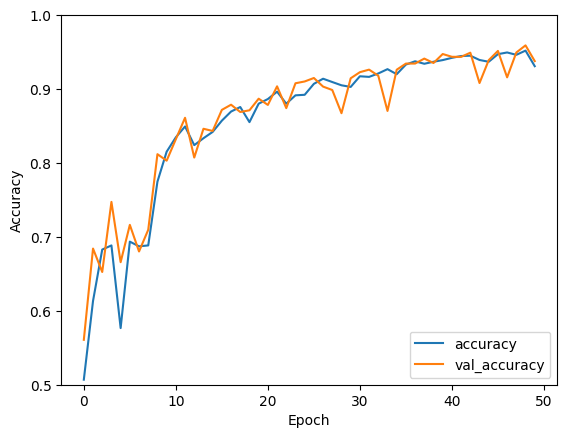

In [ ]:
show_history(history_RNN)

In [ ]:
y_pred = model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [ ]:
y_test.values

array([0., 0., 0., ..., 4., 4., 4.])

In [ ]:
y_pred_classes

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
def plot_error_histogram(y_true, y_pred, classes):
    error_indices = np.where(y_true != y_pred)[0]

    error_counts = np.bincount(y_true[error_indices], minlength=len(classes))

    plt.figure(figsize=(10, 6))
    plt.bar(classes, error_counts, color='red')
    plt.title('Classes where the model makes more errors')
    plt.xlabel('True class')
    plt.ylabel('Number of errors')
    plt.show()

def plot_histograms(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        true_indices = np.where(y_true == i)[0]
        false_indices = true_indices[np.where(y_pred[true_indices] != i)]

        false_counts = np.bincount(y_pred[false_indices], minlength=len(classes))

        plt.figure(figsize=(8, 6))
        plt.bar(classes, false_counts, color='blue')
        plt.title(f'False classifications for class {class_name}')
        plt.xlabel('Predicted class')
        plt.ylabel('Count')
        plt.show()

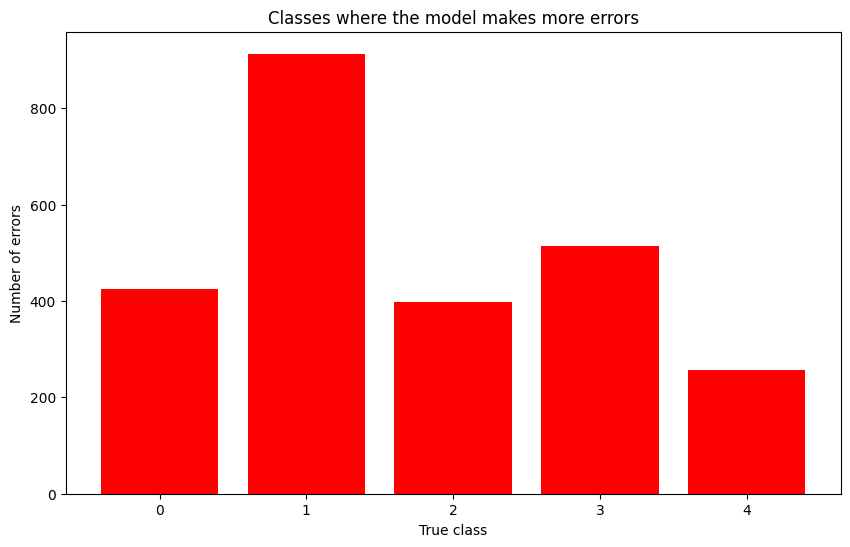

In [ ]:
plot_error_histogram(y_test.values.astype(int), y_pred_classes, class_labels)

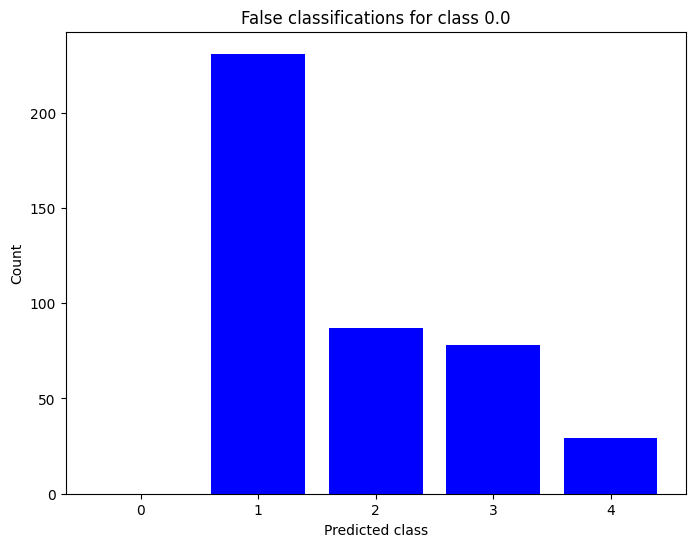

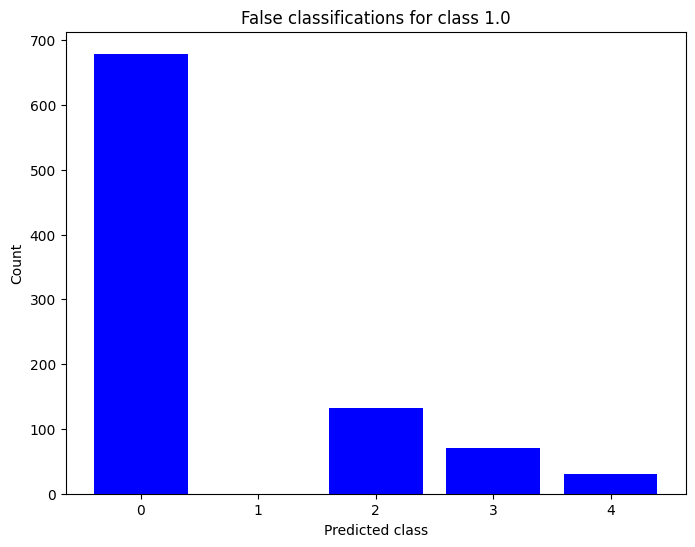

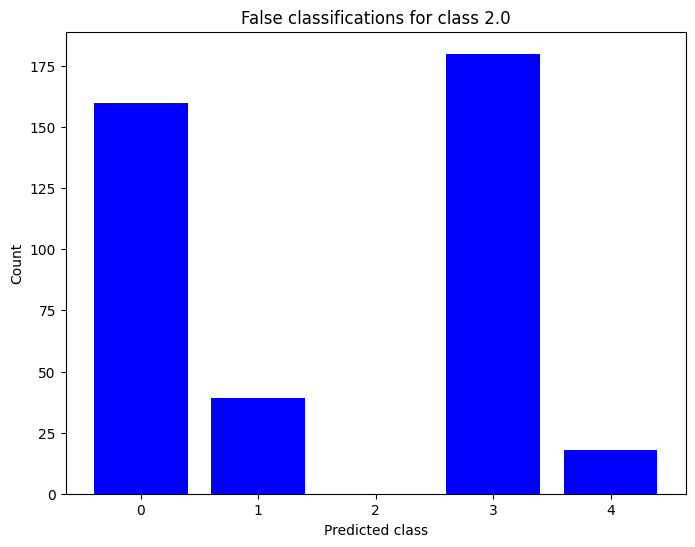

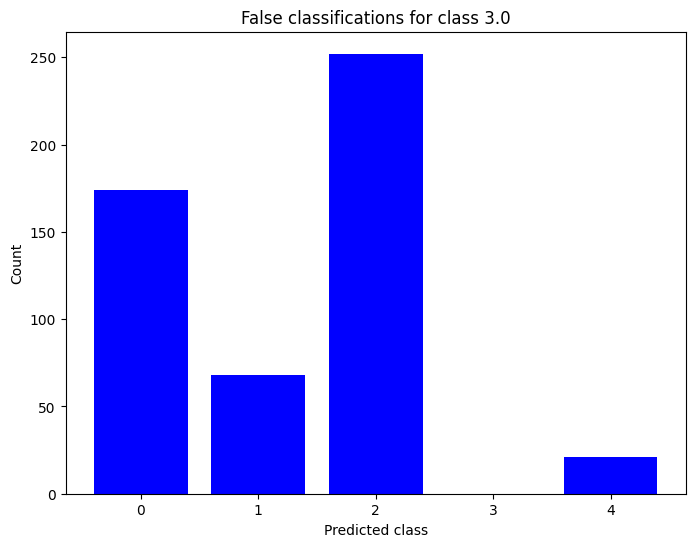

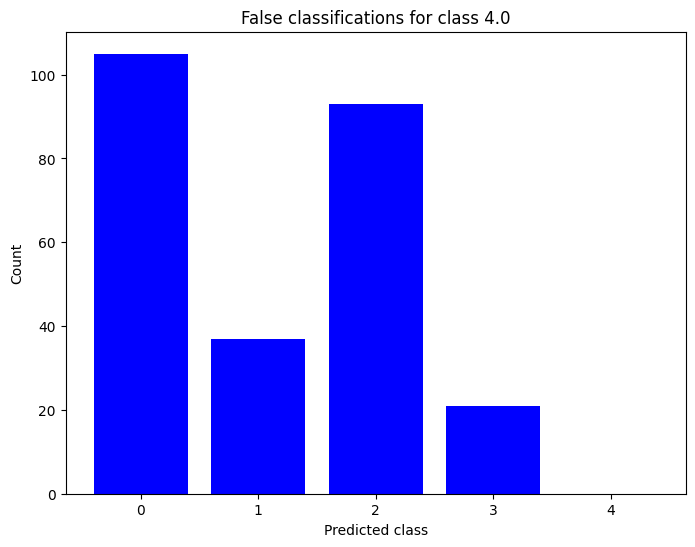

In [ ]:
plot_histograms(y_test.values.astype(int), y_pred_classes, class_labels)

В задаче обработки текста в качестве входных данных используйте отзывы клиентов, в качестве выходных - их оценки. Получите точность не ниже 90%. Текст необходимо подготовить. Также подготовьте второй датасет, но к нему примените лемматизацию (например, из nltk) текста. При прочих равных параметрах сравните результаты модели, обученной с помощью обычного словаря и с помощью лемматизированного.

In [6]:
od.download("https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data")

df = pd.read_csv('consumer-reviews-of-amazon-products/1429_1.csv', usecols=['reviews.text', 'reviews.rating'])

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bogdanzaharkin8
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products


In [7]:
df.head(5)

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [8]:
class_labels = df['reviews.rating'].unique()
class_labels

array([ 5.,  4.,  2.,  1.,  3., nan])

In [9]:
df = df.dropna(subset=['reviews.rating'])
df = df.astype({"reviews.rating": 'int', "reviews.text": 'str'})

df['reviews.rating'] = df['reviews.rating'] - 1

In [10]:
class_labels = df['reviews.rating'].unique()
class_labels

array([4, 3, 1, 0, 2])

In [11]:
df['reviews.rating'].value_counts()

,count
reviews.rating,
4,23775
3,8541
2,1499
0,410
1,402


In [ ]:
df_0_upsample = upsample(df, 'reviews.rating', 0, 10000)
df_1_upsample = upsample(df, 'reviews.rating', 1, 10000)
df_2_upsample = upsample(df, 'reviews.rating', 2, 10000)
df_3_upsample = upsample(df, 'reviews.rating', 3, 10000)
df_4_upsample = upsample(df, 'reviews.rating', 4, 10000)

train_df = pd.concat([df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

train_df['reviews.rating'].value_counts()

,count
reviews.rating,
0,10000
1,10000
2,10000
3,10000
4,10000


In [16]:
texts = train_df["reviews.text"]
ratings = train_df["reviews.rating"]

In [17]:
nlp = spacy.load("en_core_web_sm")

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_file = "glove.6B.zip"
glove_dir = "glove.6B"
urllib.request.urlretrieve(glove_url, glove_file)

import zipfile
with zipfile.ZipFile(glove_file, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

In [18]:
def preprocess_text(text, lemmatized=False):
    text = text.lower()
    text = re.sub(r'[^\w\s]|_', '', text)
    text = re.sub(r'\d+', '', text)
    if lemmatized:
        doc = nlp(text)
        final_words = [token.lemma_ for token in doc if not token.is_stop]
    else:
        final_words = [word for word in text.split() if word not in nlp.Defaults.stop_words]
    cleaned_text = ' '.join(final_words).strip()
    return cleaned_text

In [19]:
reg_texts = []
lem_texts = []
for text in texts:
    reg_texts.append(preprocess_text(text))
    lem_texts.append(preprocess_text(text, True))

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(reg_texts)
sequences = tokenizer.texts_to_sequences(reg_texts)
X_reg = pad_sequences(sequences, maxlen=200)

tokenizer_lem = Tokenizer(num_words=10000)
tokenizer_lem.fit_on_texts(lem_texts)
sequences_lem = tokenizer_lem.texts_to_sequences(lem_texts)
X_lem = pad_sequences(sequences_lem, maxlen=200)

In [20]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, ratings, test_size=0.2, stratify=ratings, random_state=42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, ratings, test_size=0.2, stratify=ratings, random_state=42)

embeddings_index = {}
with open('glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model_reg = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model_reg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_reg = model_reg.fit(X_train_reg, y_train_reg, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3604 - loss: 1.4118 - val_accuracy: 0.5160 - val_loss: 1.1401
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5518 - loss: 1.0667 - val_accuracy: 0.6379 - val_loss: 0.8670
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6465 - loss: 0.8310 - val_accuracy: 0.6910 - val_loss: 0.7130
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7046 - loss: 0.6858 - val_accuracy: 0.7186 - val_loss: 0.6375
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7250 - loss: 0.6243 - val_accuracy: 0.7293 - val_loss: 0.6153
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7504 - loss: 0.5587 - val_accuracy: 0.7551 - val_loss: 0.5445
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7612 - loss: 0.5343 - val_accuracy: 0.7516 - val_loss: 0.5450
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7792 - loss: 0.4934 - val

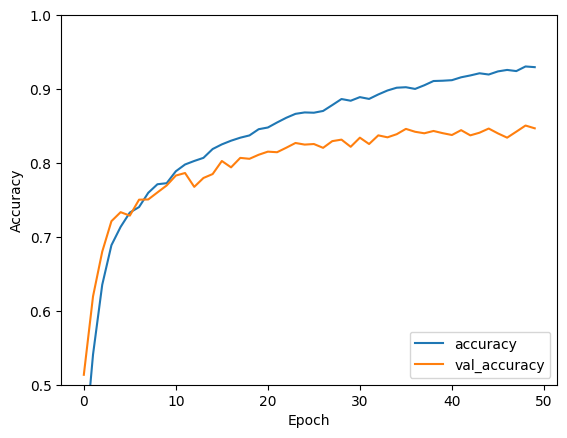

In [ ]:
show_history(history_reg)

In [ ]:
predictions_reg = model_reg.predict(X_test_reg)

predicted_classes_reg = np.argmax(predictions_reg, axis=1)
true_classes_reg = y_test_reg

print(classification_report(true_classes_reg, predicted_classes_reg))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2000
           1       0.99      1.00      0.99      2000
           2       0.92      0.98      0.95      2000
           3       0.72      0.65      0.69      2000
           4       0.72      0.71      0.72      2000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



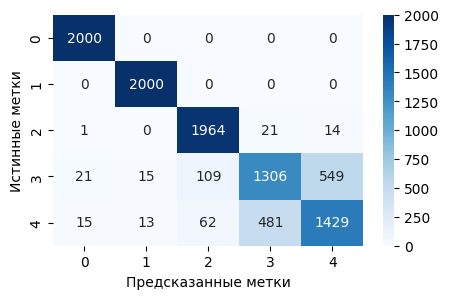

In [ ]:
conf_matrix_reg = confusion_matrix(true_classes_reg, predicted_classes_reg)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_reg, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

In [ ]:
model_lem = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model_lem.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_lem = model_lem.fit(X_train_lem, y_train_lem, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.3178 - loss: 1.4703 - val_accuracy: 0.4764 - val_loss: 1.1729
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.5351 - loss: 1.0795 - val_accuracy: 0.6650 - val_loss: 0.7811
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.6810 - loss: 0.7447 - val_accuracy: 0.7091 - val_loss: 0.6524
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.7169 - loss: 0.6259 - val_accuracy: 0.7254 - val_loss: 0.6206
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.7421 - loss: 0.5711 - val_accuracy: 0.7451 - val_loss: 0.5523
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.7607 - loss: 0.5215 - val_accuracy: 0.7569 - val_loss: 0.5477
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.7760 - loss: 0.4846 - val_accuracy: 0.7611 - val_loss: 0.5392
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.7923 - loss: 0.4610 - 

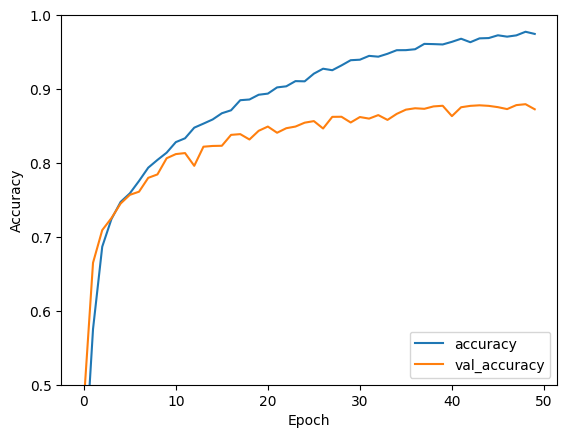

In [ ]:
show_history(history_lem)

In [ ]:
predictions_lem = model_lem.predict(X_test_lem)

predicted_classes_lem = np.argmax(predictions_lem, axis=1)
true_classes_lem = y_test_lem

print(classification_report(true_classes_lem, predicted_classes_lem))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2000
           1       0.98      1.00      0.99      2000
           2       0.93      0.97      0.95      2000
           3       0.74      0.66      0.69      2000
           4       0.72      0.74      0.73      2000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



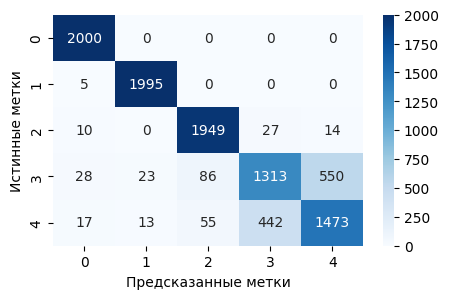

In [ ]:
conf_matrix_lem = confusion_matrix(true_classes_lem, predicted_classes_lem)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_lem, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()